In [1]:
import sys
from pathlib import Path
sys.path.append(str(Path.cwd().parent))

import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import regex

from tqdm import tqdm

In [2]:
from src import utils,physics
from src.density.nfw import NFW
from src.density.hernquist import Hernquist
from src.spatial_approximation import Lattice
from src.halo import Halo
from src.background import Potential
from src.constants import G,Msun,kpc,Myr,Gyr,cross_section,km,second

## Constants and general functions

In [9]:
# Mtot = 1.0e10 * Msun #Default halo mass in solar masses (Msun).
# Rs = 2.68441 * kpc #kpc
# c = 17
Mtot_dm = 1.15e9 * Msun
Mtot_b = 1e5 * Msun
Rs = 1.18 * kpc
c = 19
# sigma = 50 * cross_section
sigma = 0

## Setup

In [15]:
n_particles = int(1e5)
dm_density = NFW(Rs=Rs,c=c,Mtot=Mtot_dm,Rmin=1e-4*kpc,Rmax=85*Rs,unit_mass=Mtot_dm/n_particles)
density = Hernquist(Mtot=Mtot_b,Rmin=1e-4*kpc,Rmax=85*Rs,unit_mass=Mtot_b/n_particles)
density.Tdyn = dm_density.Tdyn
steps_per_Tdyn = 1000
total_run_time = 1100 * density.Tdyn
save_every = 10*density.Tdyn

halo = Halo.setup(density=density,steps_per_Tdyn=steps_per_Tdyn,n_particles=n_particles,sigma=sigma,save_every=save_every,
                  total_run_time=total_run_time)
halo.add_background(Potential.from_files(halo.lattice,Mtot=Mtot_dm,base_filename='Rank_Mass_Rad_VRad_unsorted',ntimesteps=12550000,tfinal=1100,
                                         max_time=19.605*Gyr))

Load files: 100%|██████████████████████████████████████████████████████| 251/251 [00:00<00:00, 1200.59it/s]


In [16]:
# halo.reset()
# halo.evolve(n_Tdyn=1100)
halo.evolve(n_Tdyn=81)
# halo.evolve(n_Tdyn=6)
# halo.evolve(n_Tdyn=1)

100%|███████████████████████████████████████████████████████████████| 81000/81000 [07:54<00:00, 170.60it/s]


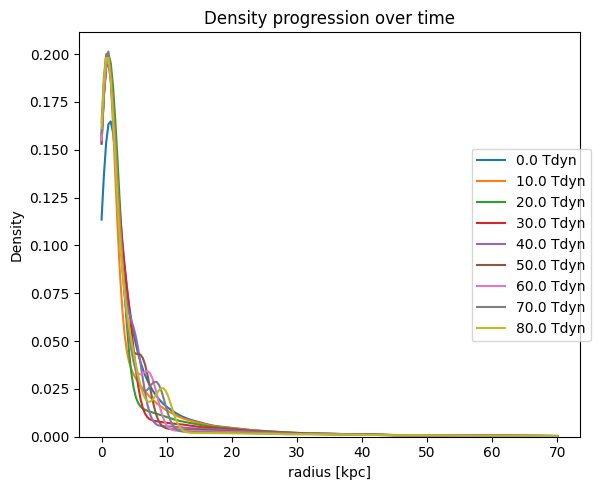

In [17]:
fig,ax = halo.plot_r_density_over_time(clip=(0,70))

<Axes: xlabel='r', ylabel='Count'>

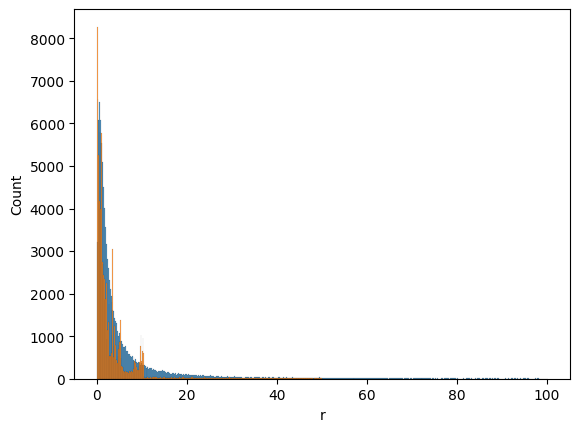

In [18]:
ax = sns.histplot(halo.initial_particles.r/kpc)
sns.histplot((halo.particles.r/kpc)[(halo.particles.r/kpc) < 50],ax=ax)

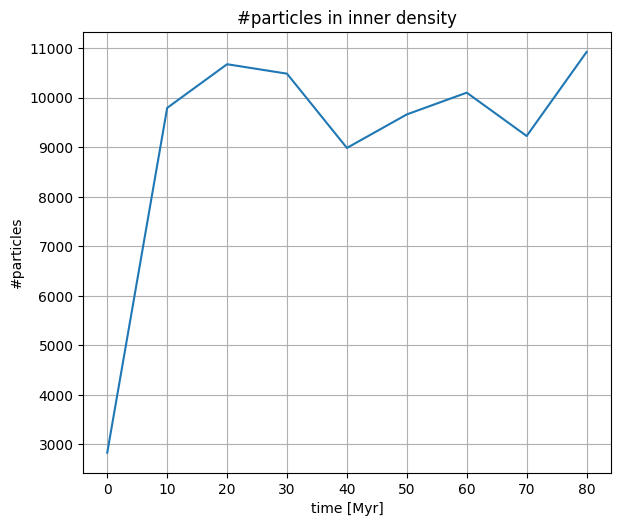

In [21]:
halo.plot_inner_core_density();

In [22]:
halo.plot_density_evolution();

TypingError: Failed in nopython mode pipeline (step: nopython frontend)
non-precise type pyobject
During: typing of argument at /home/rotembarnea/Documents/SIDM/pySIDM/src/spatial_approximation.py (52)

File "../src/spatial_approximation.py", line 52:
    def update(self,r,n_posts=None):
        <source elided>

    @staticmethod
    ^

During: Pass nopython_type_inference 

This error may have been caused by the following argument(s):
- argument 0: Cannot determine Numba type of <class 'pandas.core.series.Series'>


Text(37.722222222222214, 0.5, 'Time [Tdyn]')

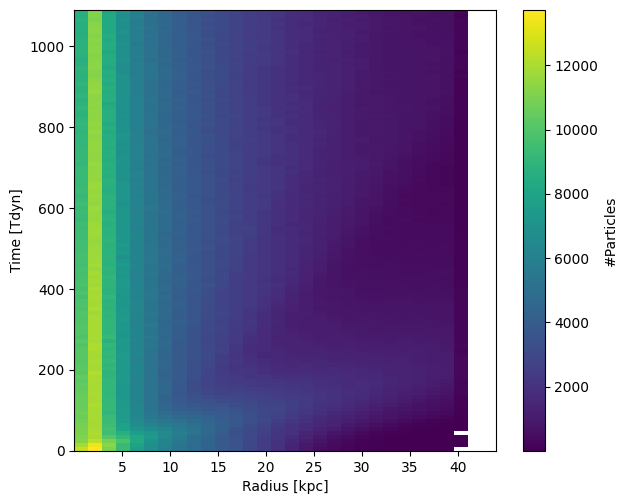

In [9]:
data = halo.saved_states.copy()
data['time'] /= halo.Tdyn
data = data[data['r'] < 40*kpc]
data['r_bin'] = data.r**2
l = Lattice(n_posts=30,start=data.r.min(),end=data.r.max()*1.1,log=False)
data['bin'] = l.posts[l(data.r)]
agg_data = data.groupby(['time','bin']).r_bin.agg('count').reset_index()
r,time = np.meshgrid(l.posts,data['time'].unique())
pad = pd.DataFrame({'time':time.ravel(),'bin':r.ravel()})
pad['r_bin'] = np.nan
agg_data = pd.concat([agg_data,pad]).drop_duplicates(['time','bin']).sort_values(['time','bin'])
agg_data['bin'] /= kpc

grid = agg_data.r_bin.to_numpy().reshape(r.shape)
fig,ax = plt.subplots(figsize=(6,5))
fig.tight_layout()
im = ax.imshow(grid,origin='lower',aspect='auto',extent=[r.min()/kpc,r.max()/kpc,time.min(),time.max()])
cbar = fig.colorbar(im,ax=ax)
cbar.set_label('#Particles')
ax.set_xlabel('Radius [kpc]')
ax.set_ylabel('Time [Tdyn]')

Text(37.722222222222214, 0.5, 'Time [Tdyn]')

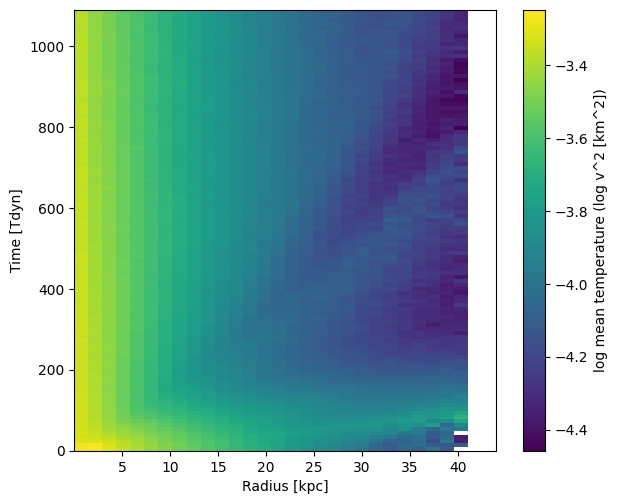

In [10]:
data = halo.saved_states.copy()
data['time'] /= halo.Tdyn
data = data[data['r'] < 40*kpc]
data['temperature'] = data.v_norm**2
l = Lattice(n_posts=30,start=data.r.min(),end=data.r.max()*1.1,log=False)
data['bin'] = l.posts[l(data.r)]
agg_data = data.groupby(['time','bin']).temperature.agg('mean').reset_index()
r,time = np.meshgrid(l.posts,data['time'].unique())
pad = pd.DataFrame({'time':time.ravel(),'bin':r.ravel()})
pad['temperature'] = np.nan
agg_data = pd.concat([agg_data,pad]).drop_duplicates(['time','bin']).sort_values(['time','bin'])
# agg_data['bin'] /= kpc

grid = agg_data.temperature.to_numpy().reshape(r.shape).copy()
fig,ax = plt.subplots(figsize=(6,5))
fig.tight_layout()
im = ax.imshow(np.log10(grid),origin='lower',aspect='auto',extent=[r.min()/kpc,r.max()/kpc,time.min(),time.max()])
cbar = fig.colorbar(im,ax=ax)
cbar.set_label('log mean temperature (log v^2 [km^2])')
ax.set_xlabel('Radius [kpc]')
ax.set_ylabel('Time [Tdyn]')

# Results:

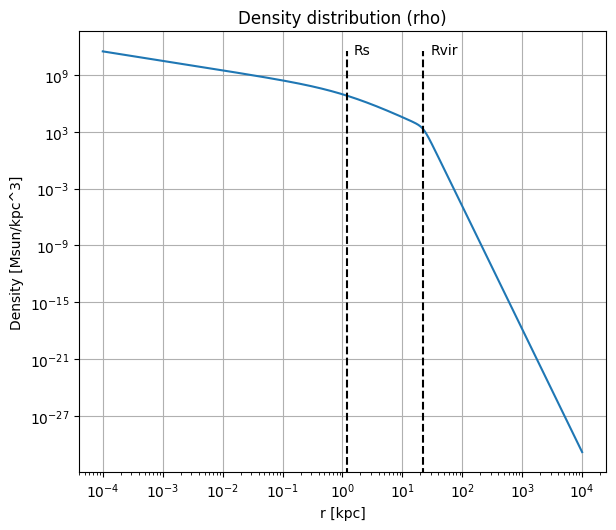

In [9]:
halo.initial_density.plot_rho();

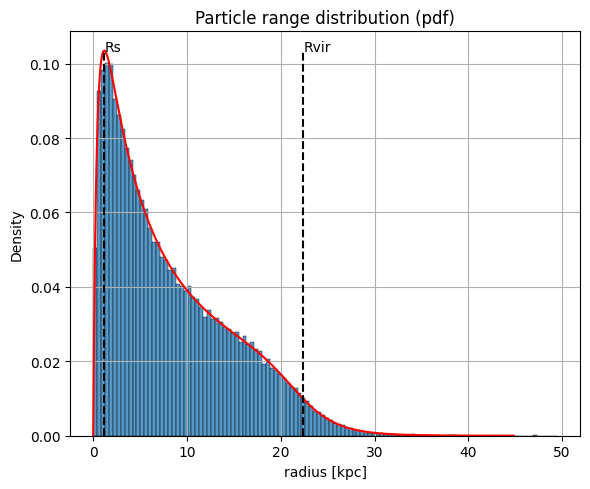

In [5]:
halo.plot_r_distribution(halo.initial_particles,cumulative=False);

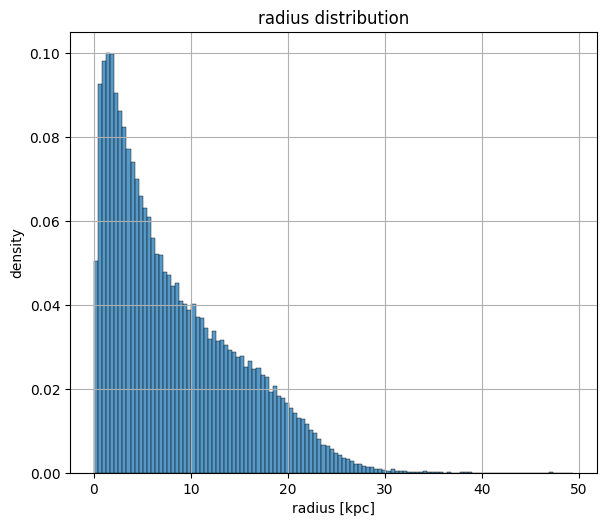

In [6]:
halo.plot_distribution('r',halo.initial_particles);

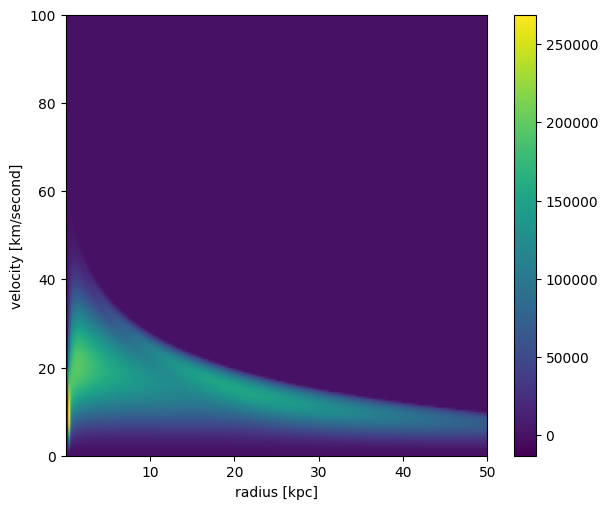

In [7]:
halo.initial_density.plot_phase_space();

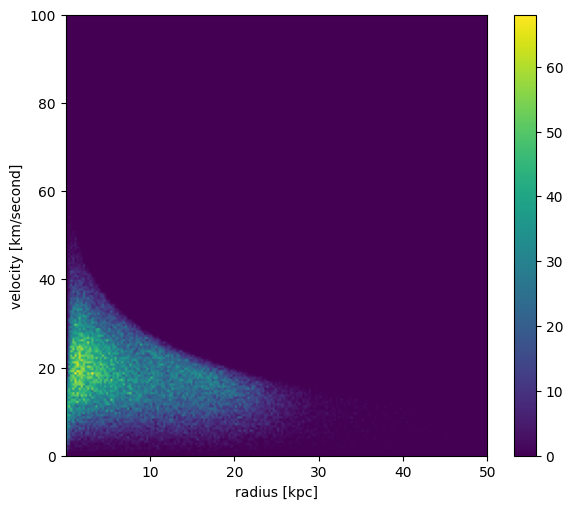

In [8]:
halo.plot_phase_space(halo.initial_particles);